## Experiential Task 2
Publicly traded companies announce earnings four times per year. These quarterly announcements convey significant information to the market about the company's performance as well as expectations about performance in the coming period. While Wall Street often focuses on whether earnings-per-share (EPS) "meets or beats" expectations, this metric represents only one data point in the announcement.

Managers supplement announced earnings with a detailed narrative disclosure which provides information helpful for interpreting performance. In this task, we will analyze these narrative disclosures using a few different machine learning approaches. Specifically: 

- We will apply topic modeling to understand the type of language in earnings announcements. 
- We will use Lasso regression to evaluate which topics best predict stock returns.
- We will train a discrete classifier to understand whether earnings announcements can be used to predict large positive returns.

This task will proceed in four general steps:
1. Load the data, pre-process, and extract features needed for our machine learning procedures (20% of grade).
2. Apply LDA to the corpus and inspect the top 5 words associated with each topic (30% of grade).
3. Use Lasso Regression to evaluate which topics most strongly predict stock returns (25% of grade).
4. Use a classifier of your choice to model the extent to which topics or words (your choice) most strongly predict large positive returns (>5% over 3-day period) (25% of grade).

Let's get started!

### Step 1: Prepare the Data
In this step, you should do the following:
1. Load the dataset using pandas. Confirm there are 12,500 rows.
2. Write a function that replaces any financial number with "financial_number." Then the function should filter out "bad" sentences, defined as those with fewer than 5 tokens OR more than 50% financial numbers. 
3. Generate a document term matrix which allows for single words and bigrams. Restrict tokens to only those that are all letters ("alpha") and at least 3 characters, but make sure to allow for "financial_number". Retain the 1,000 most common features, exclude english stop words, and exclude tokens appearing in more than 50% of documents.

#### 1.1 - Load the dataset (ExpTask2Data.csv.gz)
Use pandas to load the dataset, "ExpTask2Data.csv.gz", into a dataframe. Confirm you have 12,500 rows.

In [1]:
import pandas as pd

df = pd.read_csv("ExpTask2Data.csv.gz", compression='gzip')
print("Dataset shape (should be 12500 rows):", df.shape)

Dataset shape (should be 12500 rows): (12500, 5)


#### 1.2 - Clean out the "bad" sentences
Fill in the following function based on the criteria given above. I recommend taking the following approach (and I have sketched out a function you can update) but you are free to handle this part of the task as you wish:
- Generate a list of sentences with `sent_tokenize`
- Loop over each sentence
- Identify financial numbers with a regular expression, and replace those with "financial_number".
- Tokenize words in the sentence with `word_tokenize`, and filter out non-alpha or non-"financial_number". Retain good tokens in `good_tokens`.
- Evaluate sentence per the parameters above (5 or more tokens, no more than 50% financial numbers)

In [2]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize

def clean_sentences(txt):
    """
    This function does the following:
      - Replaces any financial number (e.g., $1,234.56 or 1234) with the token "financial_number"
      - Tokenizes the text into sentences, then words.
      - Keeps only tokens that are either 'financial_number' or words with all letters (alphabetic) of at least 3 characters.
      - Discards sentences with fewer than 5 tokens or in which more than 50% of tokens are financial numbers.
      - Returns the cleaned sentences reassembled as one string.
    """
    clean_txt = re.sub(r'\$?\d+(?:,\d{3})*(?:\.\d+)?', " financial_number ", txt)
    sentences = sent_tokenize(clean_txt)
    good_sents = []
    for sent in sentences:
        tokens = word_tokenize(sent)
        good_tokens = []
        for token in tokens:
            if token == "financial_number":
                good_tokens.append(token)
            elif token.isalpha() and len(token) >= 3:
                good_tokens.append(token.lower())
        if len(good_tokens) >= 5:
            num_fin = sum(1 for token in good_tokens if token == "financial_number")
            if (num_fin / len(good_tokens)) <= 0.5:
                good_sents.append(" ".join(good_tokens))
    return " ".join(good_sents)

Now apply this function to the earnings announcement text ("ea_text"), placing the result in a new dataframe column called "clean_sent" (this will likely take 15-20 minutes, so you may want test your function on a smaller sample before applying to the full dataframe).

In [3]:
df['clean_sent'] = df['ea_text'].apply(clean_sentences)

Before we generate the document term matrix, I'd recommend saving this dataframe so you don't have to re-run that code when continuing:

In [4]:
# To save:
df.to_csv("./task2_data_clean.csv.gz", index=False)

In [5]:
# To load:
df = pd.read_csv("./task2_data_clean.csv.gz")

In [6]:
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,htm financial_number exhibit financial_number ...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm press release exv financial_number financi...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,htm exhibit financial_number for more informat...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,htm exhibit financial_number exhibit financial...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,htm press release the dixie group inc exhibit ...
...,...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050,htm financial_number documentnews releasecorne...
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616,htm exhibit financial_number exhibit financial...
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641,htm press release press release exhibit financ...
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096,htm financial_number financial_number mks logo...


#### Step 1.3
Now we will generate our document term matrix. Note that you need use `CountVectorizer` since we are going to use LDA. I've provided you the token pattern that will allow financial_number as a single token.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stops = stopwords.words('english')
vec = CountVectorizer(token_pattern=r'\b[a-zA-Z_]{3,}[a-zA-Z]*\b',
                        ngram_range=(1,2),
                        max_features=1000,
                        stop_words=stops,
                        max_df=0.5)
dtm = vec.fit_transform(df['clean_sent'])
print("DTM shape (documents x features):", dtm.shape)

DTM shape (documents x features): (12500, 1000)


### Step 2: Fitting the LDA Model
Next, we're going to generate topics from our document term matrix using LDA. We'll do this step in four parts:
1. Fitting LDA model over a range of topics
2. Evaluating diagnostics to select "best" choice
3. Fit a final model and generate topic scores
4. Evaluate top 5 words in each topic

#### 2.1 - Tuning LDA
As in demo 5A, I suggest using `sklearn`'s implementation of LDA, which is the best option for generating topical relevance at the document level. We need to do a little tuning for our model. I recommend doing this on a smaller sample of 5,000 records to save time. You should try between 40 and 150 topics, counting by 10s. You should set `topic_word_prior` equal to 0.15 and `doc_topic_prior` to 25 divided by the number of topics. Finally, we will use the coherence score, `u_mass`, as in demo 5A to evaluate topic quality. 

I've set up a tuning loop for you to use. Fill in the code as needed:

In [8]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np
    
sample = pd.DataFrame(dtm.todense()).sample(5000, random_state=123)
vocab = vec.get_feature_names_out()
records = []

for top in range(40, 151, 10):
    print(f"Fitting LDA with {top} topics...")
    record = {'topics': top}
    lda = LDA(n_components=top,
              topic_word_prior=0.15,
              doc_topic_prior=25.0/top,
              n_jobs=-1,
              random_state=123)
    lda.fit(sample)
    umass = metric_coherence_gensim(
                            'u_mass',                     
                            topic_word_distrib=lda.components_,  
                            vocab=vocab,                  
                            dtm=sample.values             
                        )
    record['mean_umass'] = np.mean(umass)
    records.append(record)

Fitting LDA with 40 topics...
Fitting LDA with 50 topics...
Fitting LDA with 60 topics...
Fitting LDA with 70 topics...
Fitting LDA with 80 topics...
Fitting LDA with 90 topics...
Fitting LDA with 100 topics...
Fitting LDA with 110 topics...
Fitting LDA with 120 topics...
Fitting LDA with 130 topics...
Fitting LDA with 140 topics...
Fitting LDA with 150 topics...


#### 2.2 - Evaluating `umass` and selecting number of topics for final model
In this step, you should plot `umass` over the range of topics ran in the previous step. Show your plot and then choose the optimum number of topics based on your plot. You are free to use whatever plotting approach you wish. 

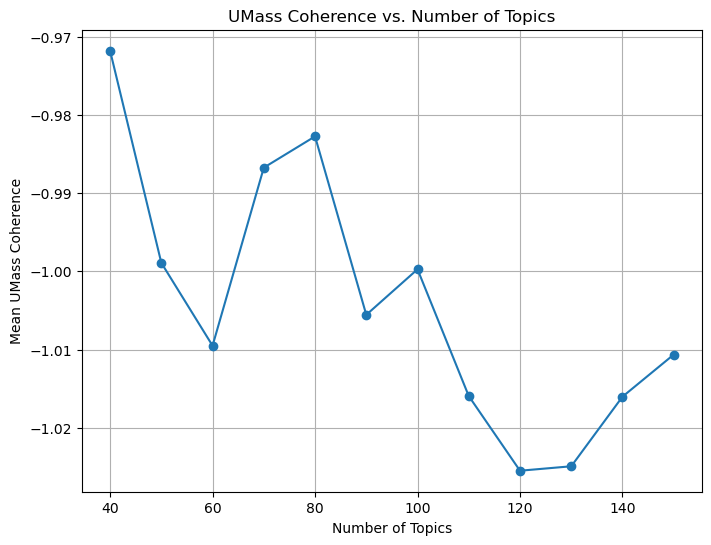

In [9]:
import matplotlib.pyplot as plt

topic_counts = [rec['topics'] for rec in records]
umass_means = [rec['mean_umass'] for rec in records]

plt.figure(figsize=(8,6))
plt.plot(topic_counts, umass_means, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Mean UMass Coherence')
plt.title('UMass Coherence vs. Number of Topics')
plt.grid(True)
plt.show()

In [10]:
optimal_topics = 40
print(f"Based on the plot, I select {optimal_topics} topics for the final model.")

Based on the plot, I select 40 topics for the final model.


**Interpret your plot and comment on the number of topics you plan to use:**

*My answer:* Based on the diagnostic plot, the best coherence score is the one that is the least negative (i.e. closest to 0). In this case, at 40 topics the mean u_mass is -0.97178, which is higher than (or less negative than) the scores obtained for 50 topics (-0.99891), 60 topics (-1.00951), and the other configurations. Although there is a slight bump around 70 and 80 topics, their scores (around -0.98674 and -0.98274, respectively) are still lower than the score for 40 topics.

Since the u_mass coherence measure tends to be more interpretable when it is closer to 0, achieving this value at 40 topics suggests that the model has struck a good balance between granularity and interpretability. In other words, with 40 topics, the model is complex enough to capture the underlying themes in the earnings announcements without overfitting or producing topics that are too fragmented. Therefore, I plan to use 40 topics for the final model, as it provides the best trade-off between coherence and detail based on the data.

#### Step 2.3
Now, fit a final LDA model using the number of topics chosen in the prior step and use it to transform the data.

In [11]:
final_lda = LDA(n_components=optimal_topics,
                topic_word_prior=0.15,
                doc_topic_prior=25.0/optimal_topics,
                n_jobs=-1,
                random_state=123)
final_lda.fit(dtm)
topics = final_lda.transform(dtm)
print("Final topic matrix shape (documents x topics):", topics.shape)

Final topic matrix shape (documents x topics): (12500, 40)


In [12]:
topics

array([[0.00060749, 0.00101659, 0.01029188, ..., 0.05032071, 0.00160664,
        0.00037854],
       [0.00152324, 0.00694696, 0.00219167, ..., 0.00179034, 0.0014505 ,
        0.00616338],
       [0.12213554, 0.00251901, 0.05489289, ..., 0.00078129, 0.00077721,
        0.10728971],
       ...,
       [0.00173762, 0.00161715, 0.00806079, ..., 0.00437949, 0.00512796,
        0.00525164],
       [0.08261608, 0.00801213, 0.00209743, ..., 0.00317671, 0.00812427,
        0.01839252],
       [0.09250566, 0.00165018, 0.00751739, ..., 0.0013421 , 0.07724908,
        0.00119458]])

#### 2.4 - Evaluate topic words
The final step in this part of the task is to evaluate the words in your topics. Word intrusion tasks are a good way to validate topics in an objective manner. We will not follow through on a full word intrusion task, but I would like you to display the top 5 words in each topic and a randomly chosen word from the vocabulary, separately identified as an intruder.

Fill in this code to generate the top 5 words in each topic plus an intruder:

In [13]:
import random

topn = 5 
topics_words = {}
for topic_idx, topic in enumerate(final_lda.components_):
    top_indices = topic.argsort()[-topn:][::-1]
    top_words = [vocab[i] for i in top_indices]
    intruder_candidates = list(set(vocab) - set(top_words))
    intruder = random.choice(intruder_candidates)
    topics_words[topic_idx] = {'top_words': top_words, 'intruder': intruder}

for topic_idx, words in topics_words.items():
    print(f"Topic {topic_idx}: Top words: {words['top_words']} | Intruder: {words['intruder']}")

Topic 0: Top words: ['restructuring', 'financial_number restructuring', 'restructuring charges', 'charges financial_number', 'eps'] | Intruder: eps financial_number
Topic 1: Top words: ['gas', 'natural', 'natural gas', 'oil', 'derivative'] | Intruder: impairment charges
Topic 2: Top words: ['page', 'page financial_number', 'advertising', 'net revenue', 'media'] | Intruder: additional information
Topic 3: Top words: ['income loss', 'net loss', 'ebitda', 'adjusted ebitda', 'stockholders'] | Intruder: losses
Topic 4: Top words: ['net sales', 'earnings financial_number', 'group', 'gross profit', 'operating earnings'] | Intruder: add
Topic 5: Top words: ['net loss', 'income loss', 'loss per', 'gaap net', 'financial_number gaap'] | Intruder: may differ
Topic 6: Top words: ['ended march', 'financial_number first', 'april', 'april financial_number', 'million first'] | Intruder: principles
Topic 7: Top words: ['june', 'june financial_number', 'six', 'six months', 'ended june'] | Intruder: busin

### Step 3: Using Lasso to evaluate topic informativeness
In this portion of the task, you'll use Lasso regression to evaluate which topics exhibit the strongest associations with stock returns, which is labeled as "BHAR0_2" (or buy-and-hold abnormal returns from days 0 to 2). Note that this column is in percentage points (i.e., -4.5 indicates a return of -4.5%).

You should proceed as follows:
1. Identify the optimum out-of-sample value for `alpha` (the primary regularization parameter) using `RandomizedSearchCV`. You should try 100 random values in the range between 0.00001 and 0.02.
2. Analyze results of the best fit models. How many topics exhibit non-zero associations with returns? Which topic exhibits the strongest negative and positive associations (two total)?

#### 3.1 - Tuning the Lasso model
To tune the model, you first need do split your data into a training and testing sample. I've set most of this up for you; Replace `X` and `Y` with the datasets needed to conduct this test and update the function have a training sample of 80% and validation sample of 20%:

In [14]:
from sklearn.model_selection import train_test_split

Xtopic_train, Xtopic_test, Ytopic_train, Ytopic_test = train_test_split(
    topics, df['BHAR0_2'], test_size=0.2, random_state=123)

Next, you should set up your lasso model, parameter grid, and randomized searcher. Use these parameters for the search:
- You parameter grid should include 100 random values for `alpha` between 0.00001 and 0.02. 
- Your randomized search should run 50 times and use 5-fold cross-validation. 
- You should use `neg_root_mean_squared_error` for scoring.
- You should use `random_state=123` wherever possible.

Fill in the code below to set this up:

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso

param_grid = {
    'alpha': np.random.uniform(0.00001, 0.02, 100),
    'random_state': [123]
}
lasso = Lasso(max_iter=10000)
rus = RandomizedSearchCV(lasso, param_grid, n_iter=50, cv=5,
                         scoring='neg_root_mean_squared_error', random_state=123, n_jobs=-1)
rus.fit(Xtopic_train, Ytopic_train)

RandomizedSearchCV(cv=5, estimator=Lasso(max_iter=10000), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': array([4.66164256e-03, 4.22523326e-05, 1.31658323e-02, 5.06756632e-03,
       1.00504100e-02, 2.80813544e-03, 7.89911588e-03, 1.47060441e-02,
       1.91323194e-02, 7.54907628e-03, 1.11833628e-02, 7.40296058e-03,
       1.65843079e-02, 1.32342309e-02, 1.79468502e-02, 4.15558773e-0...
       1.44487355e-02, 8.08828813e-03, 1.84018342e-02, 1.84806642e-02,
       8.49337834e-03, 1.08131197e-02, 1.46422407e-02, 1.02682015e-02,
       1.49137090e-02, 1.78906908e-02, 5.28128326e-03, 3.10244681e-03,
       3.46345915e-03, 9.32594803e-04, 9.73469192e-03, 3.71224384e-03,
       1.32060609e-02, 1.01566344e-02, 6.26769586e-04, 1.09576199e-02]),
                                        'random_state': [123]},
                   random_state=123, scoring='neg_root_mean_squared_error')

To evaluate performance by `alpha`, prepare a scatter plot that shows the validation `neg_root_mean_squared_error` vs. `alpha` (**HINT**: results from the randomized search are in `rus.cv_results_`, which is a dictionary).

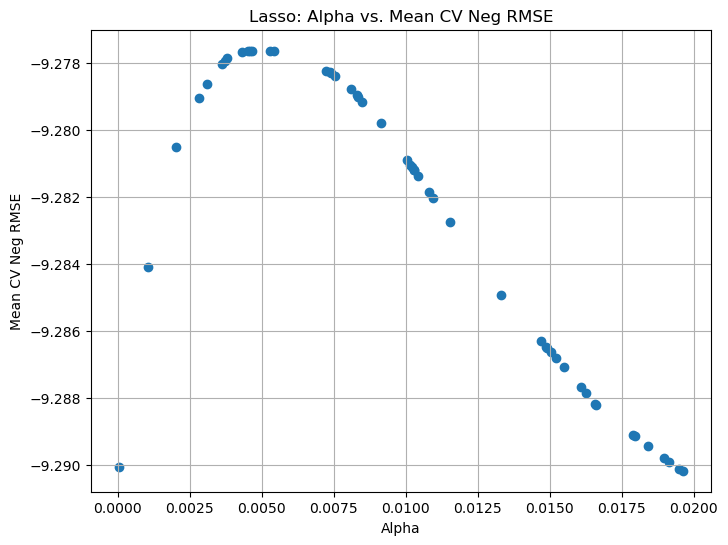

In [16]:
alphas = rus.cv_results_['param_alpha'].data
scores = rus.cv_results_['mean_test_score']

plt.figure(figsize=(8,6))
plt.scatter(alphas, scores)
plt.xlabel('Alpha')
plt.ylabel('Mean CV Neg RMSE')
plt.title('Lasso: Alpha vs. Mean CV Neg RMSE')
plt.grid(True)
plt.show()

Now print the optimum value for `alpha`:

In [17]:
best_alpha = rus.best_params_['alpha']
print("Optimum alpha from tuning:", best_alpha)

Optimum alpha from tuning: 0.004661642556671825


#### 3.2 Interpreting Lasso results
To finish up this step, I'd like you to identify:

1. How many coefficients (each of which corresponds to a topic) are non-zero
2. Which topic has the most negative coefficient?
3. Which topic has the most positive coefficient?

Let's start with non-zero coefficients. Fill in the cell below to print out the number of coefficients not equal to zero:

In [18]:
best_lasso = rus.best_estimator_
coefficients = best_lasso.coef_
nonzero_count = np.sum(coefficients != 0)
print("Number of non-zero coefficients (topics with non-zero association):", nonzero_count)


Number of non-zero coefficients (topics with non-zero association): 18


Now identify the most positive and most negative topics and print associated words (**HINT**: `argmax()` and `argmin()` make this very straightforward). 

Print out both the values of these coefficients and their indices:

In [19]:
most_pos = np.argmax(coefficients)
most_neg = np.argmin(coefficients)
print(f"The most positive coefficient corresponds to topic {most_pos} and has a value {coefficients[most_pos]:.4f}.")
print(f"The most negative coefficient corresponds to topic {most_neg} and has a value {coefficients[most_neg]:.4f}.")


The most positive coefficient corresponds to topic 25 and has a value 3.8514.
The most negative coefficient corresponds to topic 3 and has a value -4.1851.


Now, print the top 5 words corresponding to each of these two topics:

In [20]:
# For the most positive topic:
pos_topic = final_lda.components_[most_pos]
pos_top_indices = pos_topic.argsort()[-topn:][::-1]
pos_words = [vocab[i] for i in pos_top_indices]
print(f"Topic {most_pos} words: {'|'.join(pos_words)}")

# For the most negative topic:
neg_topic = final_lda.components_[most_neg]
neg_top_indices = neg_topic.argsort()[-topn:][::-1]
neg_words = [vocab[i] for i in neg_top_indices]
print(f"Topic {most_neg} words: {'|'.join(neg_words)}")

Topic 25 words: eps|billion|financial_number billion|diluted eps|eps financial_number
Topic 3 words: income loss|net loss|ebitda|adjusted ebitda|stockholders


**QUESTION**: Do you find this answer intuitive? Why or why not?

*INSERT ANSWER HERE*: Yes, I find the answer intuitive. The Lasso regression highlights two topics with distinct financial language that aligns with how investors react to earnings announcements. For example, Topic 25 contains words like "eps," "billion," and "financial_number," which are generally associated with robust earnings figures and overall positive financial performance. This kind of language is typically interpreted as a sign of strong earnings, which would be expected to drive positive abnormal returns. On the other hand, Topic 3 is dominated by terms such as "income loss," "net loss," "ebitda," and "adjusted ebitda," which clearly signal negative financial performance. Announcements with these terms are likely to be met with negative market reactions.

Thus, the fact that Lasso regression identifies these topics as having the strongest associations with BHAR0_2 (buy-and-hold abnormal returns) is consistent with financial intuition—positive performance indicators predict positive returns, while indicators of losses predict negative returns.

### Step 4: Use a classifier to predict large positive returns
The final part of this task is to use a classifier of your choice to predict large positive returns. You can use the document-term matrix or topic-matrix. You're also free to tune the model as you wish. Training classifiers can be time consuming, so I'm going to use an approach to this section called *specification grading*, meaning you can choose to omit parts of the process for a reduced grade.

Grading for this part will be done as follows:

1. Set up, train, and evaluate at least one classifier: If this portion is done perfectly and nothing else is done, you'll receive 50% credit for this part.
2. Apply robust tuning procedures to one or more models: If you tune multiple hyperparameters for the one model you fit in step 1, you'll receive an additional 10-20% (max grade 70%) credit, depending on extent of tuning. If you tune two or more models properly, this scale increases to 20-40% (max grade 90%).
3. Finally, the last 10% will be based on your best fit model. Specifically, using the validation data set up below, you should print your classification report. The best macro-F1 score in the class will receive 10% (100% cumulative) second best 9.5%, and so forth.

#### 4.1 - Data set-up and single model training
I'll help you set up the data so we all start from the same place. Note that I'm going to set up two sets of "X" data, one based on the DTM and the other on the topic matrix. You can use either (or both if you consider multiple models):

In [21]:
YLR = (df['BHAR0_2']>5).astype(int)
train_Xdtm, test_Xdtm, train_Xtopic, test_Xtopic, train_YLR, test_YLR = train_test_split(np.asarray(dtm.todense()),topics,YLR,train_size=0.80,random_state=123)

Next, you should fill in the cell below with code to train at least one model:

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

X_train = train_Xtopic  
X_test = test_Xtopic    
y_train = train_YLR    
y_test = test_YLR

# 1. Logistic Regression (default settings)
lr_default = LogisticRegression(max_iter=1000, random_state=123)
lr_default.fit(X_train, y_train)
y_pred_lr = lr_default.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
print("Default Logistic Regression Macro F1 Score:", f1_lr)

# 2. Support Vector Machine (default settings)
svm_default = SVC(probability=True, random_state=123)
svm_default.fit(X_train, y_train)
y_pred_svm = svm_default.predict(X_test)
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
print("Default SVM Macro F1 Score:", f1_svm)

# 3. Random Forest (default settings)
rf_default = RandomForestClassifier(random_state=123)
rf_default.fit(X_train, y_train)
y_pred_rf = rf_default.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print("Default Random Forest Macro F1 Score:", f1_rf)

# 4. Gradient Boosting Classifier (default settings)
gb_default = GradientBoostingClassifier(random_state=123)
gb_default.fit(X_train, y_train)
y_pred_gb = gb_default.predict(X_test)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
print("Default Gradient Boosting Macro F1 Score:", f1_gb)

Default Logistic Regression Macro F1 Score: 0.4323342415985468
Default SVM Macro F1 Score: 0.4323342415985468
Default Random Forest Macro F1 Score: 0.444405617549165
Default Gradient Boosting Macro F1 Score: 0.43653805983834554


#### 4.2 - Model Tuning
Here, you should insert code you use to tune your classifier. You can insert additional cells if needed, or skip this step and accept a lower grade if desired.

In [24]:
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV

### 1. Logistic Regression with RandomizedSearchCV
param_dist_lr = {
    'C': loguniform(1e-4, 1e3),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}
lr = LogisticRegression(max_iter=1000, random_state=123)
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist_lr,
    n_iter=100,                   
    scoring='f1_macro',
    cv=5,                        
    random_state=123,
    n_jobs=-1                     
)
random_search_lr.fit(X_train, y_train)
best_lr_params = random_search_lr.best_params_
best_lr_score = random_search_lr.best_score_

print("=== Logistic Regression Results ===")
print("Best Params:", best_lr_params)
print(f"Best CV Macro F1 Score: {best_lr_score:.4f}")

### 2. Support Vector Machine (SVM) with RandomizedSearchCV
param_dist_svm = {
    'kernel': ['linear', 'rbf'],
    'C': loguniform(1e-4, 1e3),
    'gamma': loguniform(1e-4, 1e2),  
    'class_weight': [None, 'balanced']
}
svm = SVC(probability=True, random_state=123)
random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist_svm,
    n_iter=100,
    scoring='f1_macro',
    cv=5,
    random_state=123,
    n_jobs=-1
)
random_search_svm.fit(X_train, y_train)
best_svm_params = random_search_svm.best_params_
best_svm_score = random_search_svm.best_score_

print("=== SVM Results ===")
print("Best Params:", best_svm_params)
print(f"Best CV Macro F1 Score: {best_svm_score:.4f}")

### 3. Random Forest with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}
rf = RandomForestClassifier(random_state=123)
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=100,
    scoring='f1_macro',
    cv=5,
    random_state=123,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train)
best_rf_params = random_search_rf.best_params_
best_rf_score = random_search_rf.best_score_

print("=== Random Forest Results ===")
print("Best Params:", best_rf_params)
print(f"Best CV Macro F1 Score: {best_rf_score:.4f}")


### 4. Gradient Boosting with RandomizedSearchCV
param_dist_gb = {
    'n_estimators': randint(50, 500),
    'learning_rate': loguniform(1e-4, 1),
    'max_depth': randint(2, 50),
    'subsample': uniform(0.5, 0.5),  # from 0.5 to 1.0
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
gb = GradientBoostingClassifier(random_state=123)
random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=100,
    scoring='f1_macro',
    cv=5,
    random_state=123,
    n_jobs=-1
)
random_search_gb.fit(X_train, y_train)
best_gb_params = random_search_gb.best_params_
best_gb_score = random_search_gb.best_score_

print("=== Gradient Boosting Results ===")
print("Best Params:", best_gb_params)
print(f"Best CV Macro F1 Score: {best_gb_score:.4f}")

=== Logistic Regression Results ===
Best Params: {'C': 0.0964848550502369, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Macro F1 Score: 0.5184
=== SVM Results ===
Best Params: {'C': 0.057622271934204, 'class_weight': 'balanced', 'gamma': 17.32663078359235, 'kernel': 'rbf'}
Best CV Macro F1 Score: 0.5154
=== Random Forest Results ===
Best Params: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 210}
Best CV Macro F1 Score: 0.5307
=== Gradient Boosting Results ===
Best Params: {'learning_rate': 0.8600496820728207, 'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 13, 'n_estimators': 444, 'subsample': 0.8163894293124714}
Best CV Macro F1 Score: 0.4997


#### 4.3 - Report final classification report
Here, you should report your final classification report:

In [25]:
from sklearn.metrics import classification_report

results = {
    'LogisticRegression': best_lr_score,
    'SVM': best_svm_score,
    'RandomForest': best_rf_score,
    'GradientBoosting': best_gb_score
}
best_model_name = max(results, key=results.get)
print("=== Best Model Based on RandomizedSearchCV (CV Macro F1) ===")
print(best_model_name, "->", results[best_model_name])

if best_model_name == 'LogisticRegression':
    final_model = random_search_lr.best_estimator_
elif best_model_name == 'SVM':
    final_model = random_search_svm.best_estimator_
elif best_model_name == 'RandomForest':
    final_model = random_search_rf.best_estimator_
elif best_model_name == 'Gradient Boosting':
    final_model = random_search_gb.best_estimator_

y_pred = final_model.predict(X_test)

print("\nClassification Report for the Best Model on the Test Set:")
print(classification_report(y_test, y_pred))

=== Best Model Based on RandomizedSearchCV (CV Macro F1) ===
RandomForest -> 0.5306963009680536

Classification Report for the Best Model on the Test Set:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1904
           1       0.28      0.36      0.32       596

    accuracy                           0.63      2500
   macro avg       0.53      0.54      0.53      2500
weighted avg       0.66      0.63      0.64      2500

